# Two moons

We learn the two moons distribution, conditioned on the class label.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from neural_flow import Flow, train
from neural_flow.bijectors import (
    ShiftBounds,
    chain,
    NeuralSplineCoupling,
    Roll,
    rolling_spline_coupling,
)
from neural_flow import distributions as dist
import optax
import jax
import jax.numpy as jnp

Output()

0.34703361988067627


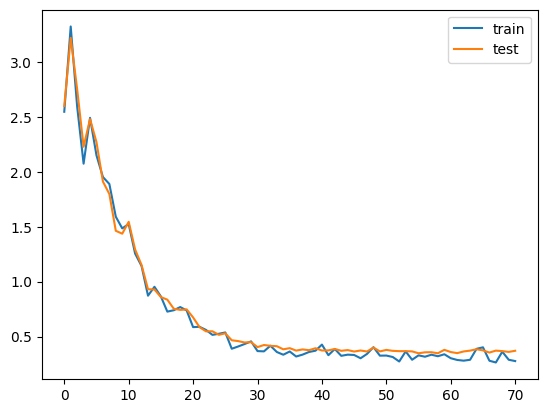

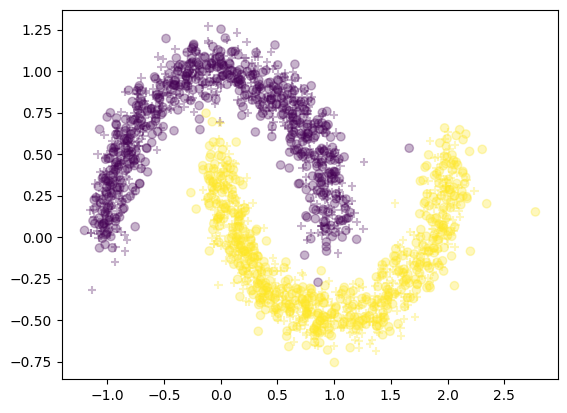

In [2]:
X, C = make_moons(10_000, noise=0.1, random_state=1)
X_train, X_test, C_train, C_test = train_test_split(X, C, random_state=1)

flow = Flow(rolling_spline_coupling(2))

variables, best_epoch, train_losses, test_losses = train(
    flow,
    X_train,
    X_test,
    C_train,
    C_test,
    epochs=100,
)
print(test_losses[best_epoch])

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()

Cm = C_test[:1000]
Xm = flow.apply(variables, Cm, method="sample")

plt.figure()
plt.scatter(*Xm.T, c=Cm, marker="o", alpha=0.3)
plt.scatter(*X_test[:1000].T, c=C_test[:1000], marker="+", alpha=0.3);

The following code shows how the base distribution is successively transformed into the target distribution by the bijectors applied in reverse.

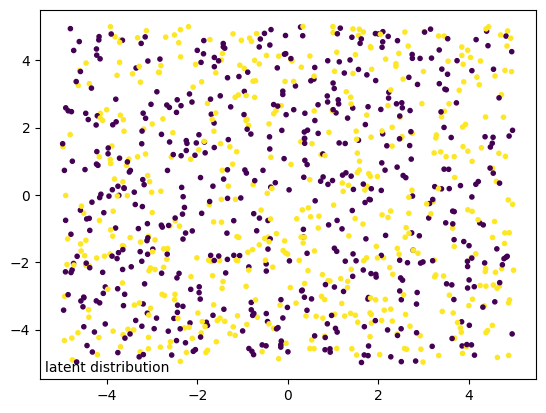

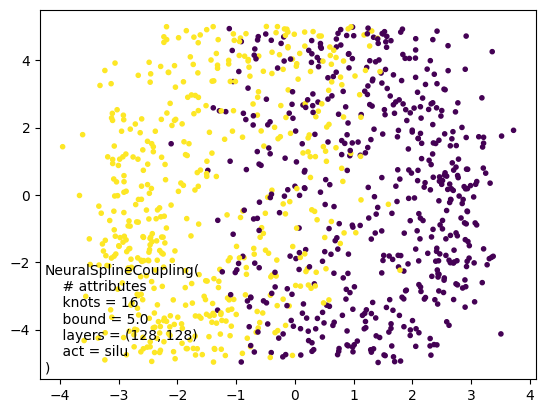

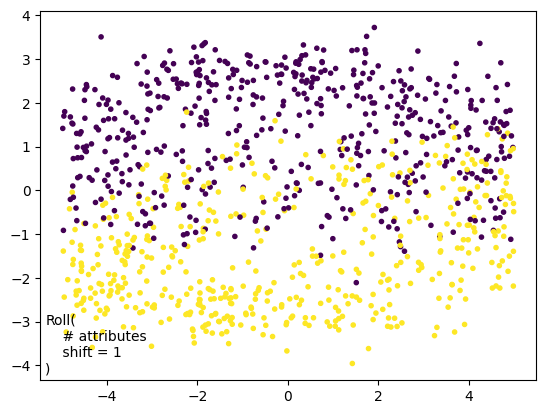

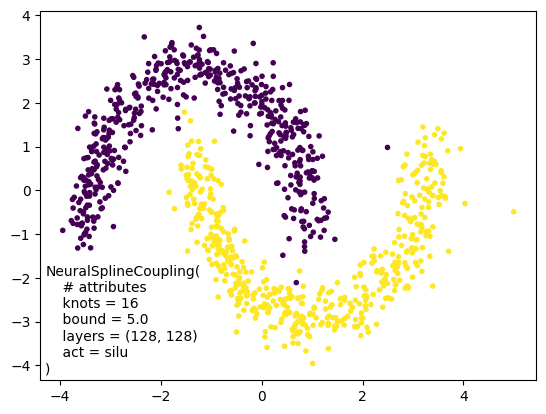

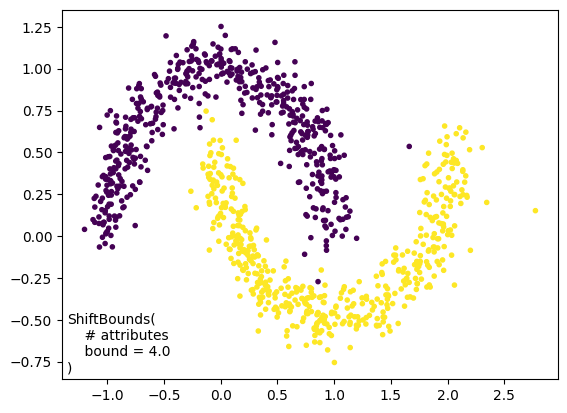

In [3]:
size = 1000
x = flow.latent.sample(size, jax.random.PRNGKey(0))

plt.figure()
plt.scatter(*x.T, marker=".", c=Cm)
plt.text(0.01, 0.02, "latent distribution",
         transform=plt.gca().transAxes)

for i, bijector in reversed(list(enumerate(flow.bijector.bijectors))):
    key = f"bijectors_{i}"
    var = {
        "batch_stats": variables["batch_stats"]["bijector"].get(key, {}),
        "params": variables["params"]["bijector"].get(key, {})
    }
    x = bijector.apply(var, x, Cm.reshape(-1, 1), method="inverse")
    plt.figure()
    plt.text(0.01, 0.02,
             f"{bijector!s}", transform=plt.gca().transAxes)
    plt.scatter(*x.T, marker=".", c=Cm)

Now we test the learning without conditional features. We learn the two-moons distribution without using class labels.

For demonstration purposes, we set the bijector chain explicitly and the latent distribution to normal.

Output()

1.0441499948501587


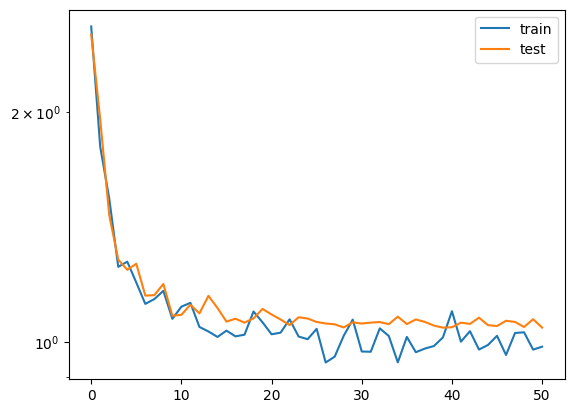

In [5]:
flow = Flow(
    chain(
        ShiftBounds(),
        NeuralSplineCoupling(layers=(256,)*6),
        Roll(),
        NeuralSplineCoupling(layers=(256,)*6),
    ),
    dist.TruncatedNormal()
)

variables, best_epoch, train_losses, test_losses = train(
    flow, X_train, X_test
)
print(test_losses[best_epoch])

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.semilogy()
plt.legend();

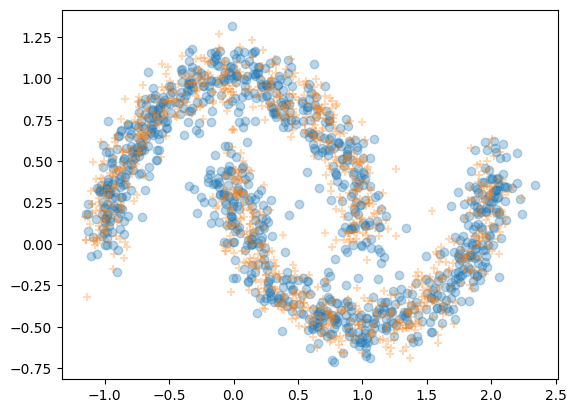

In [6]:
Xm = flow.apply(variables, 1000, method="sample")
plt.scatter(*Xm.T, marker="o", alpha=0.3)
plt.scatter(*X_test[:1000].T, marker="+", alpha=0.3);

Let's see again how the base distribution is successively transformed into the target distribution.

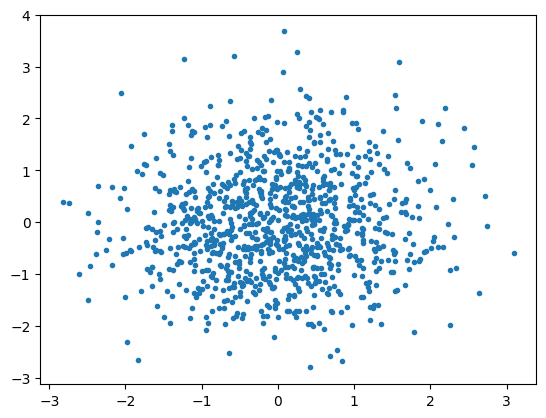

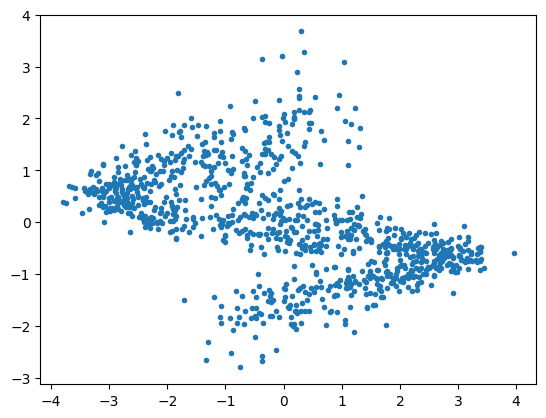

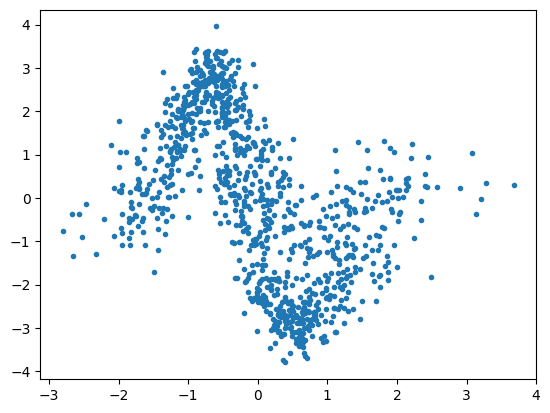

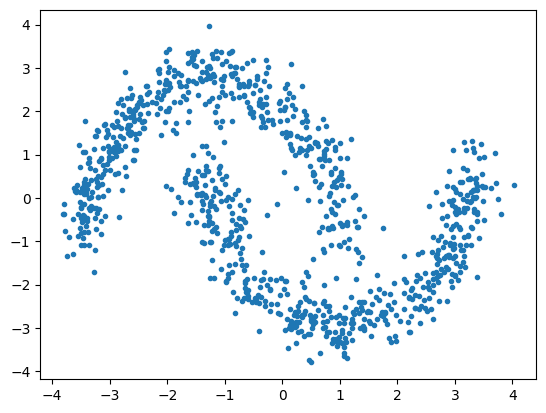

In [7]:
size = 1000
c = jnp.zeros((size, 0))
x = flow.latent.sample(size, jax.random.PRNGKey(0))

for i, bijector in reversed(list(enumerate(flow.bijector.bijectors))):
    key = f"bijectors_{i}"
    var = {
        "batch_stats": variables["batch_stats"]["bijector"].get(key, {}),
        "params": variables["params"]["bijector"].get(key, {})
    }
    plt.figure()
    plt.scatter(*x.T, marker=".")
    x = bijector.apply(var, x, c, method="inverse")